In this Notebook I will show how to solve MNIST dataset with Multilayer Perceptron.

### Import

In [1]:
!pip install -q keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from keras.datasets import mnist
from keras.callbacks import EarlyStopping

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import os
import random as rn
import numpy as np

# Randomness control
os.environ['PYTHONHASHSEED'] = '0'
RANDOM_SEED = 3939
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, 
                              inter_op_parallelism_threads=1)

tf.set_random_seed(RANDOM_SEED)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
keras.backend.set_session(sess)

Using TensorFlow backend.


### Constants

In [0]:
CLASS_NUMBER = 10

IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28

TRAIN_IMAGE_NUMBER = 60000
TEST_IMAGE_NUMBER = 10000

### Loading Data

MNIST data is being built into ``from keras.datasets`` module.

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### Data Visualisation

In [0]:
def show_digits(X_train, y_train, rows_num=6):    
    figure, axes = plt.subplots(nrows=rows_num, ncols=6, sharex=True, sharey=True, figsize=(20, rows_num * 2))
    
    for row_index in range(rows_num):
        ax_row = axes[row_index]
        images = X_train[(row_index*8):(row_index+1)*8]
        labels = y_train[(row_index*8):(row_index+1)*8]
        
        for ax, img, label in zip(ax_row, images, labels):
            ax.imshow(img, cmap='gray_r')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_title("Label - {}".format(label))

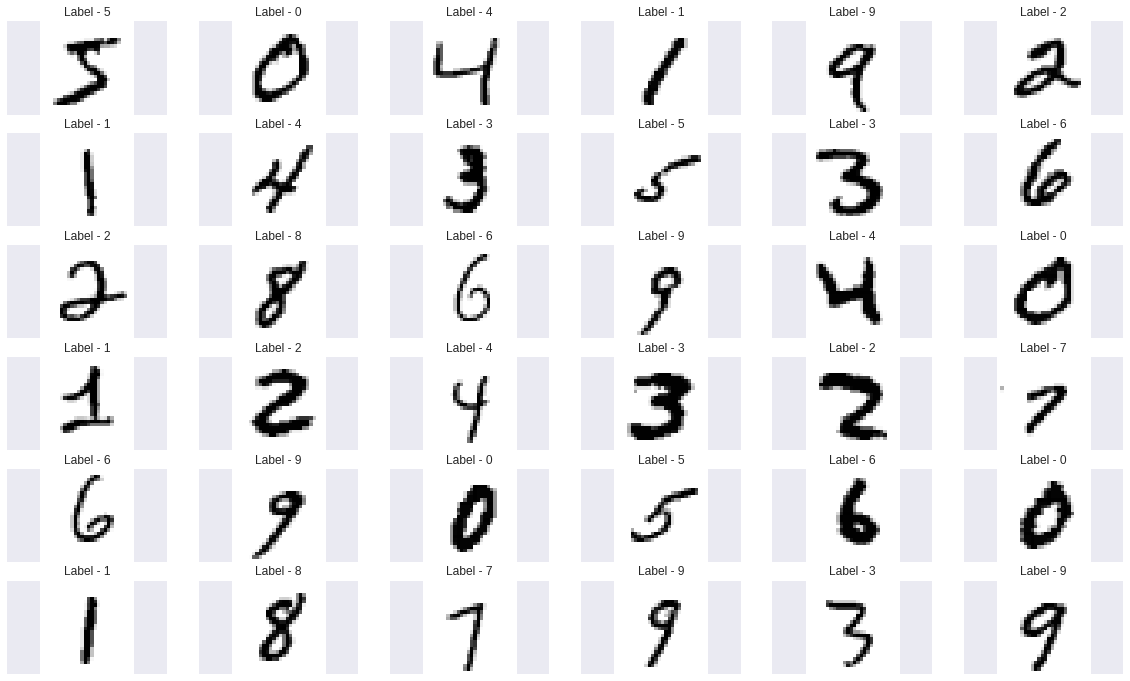

In [5]:
show_digits(X_train, y_train)

### Data Preprocessing

Unwrapping image matrices into vectors

In [6]:
print("Training data - before unwrapping: ")
print(" - shape: {}".format(X_train.shape))
print(" - label: {}".format(y_train.shape))
print("Test data - before unwrapping: ")
print(" - shape: {}".format(X_test.shape))
print(" - label: {}".format(y_test.shape))

X_train = X_train.reshape(TRAIN_IMAGE_NUMBER, IMAGE_WIDTH * IMAGE_HEIGHT)
X_test = X_test.reshape(TEST_IMAGE_NUMBER, IMAGE_WIDTH * IMAGE_HEIGHT)

print("\nTraining data - after unwrapping: ")
print(" - shape: {}".format(X_train.shape))
print(" - label: {}".format(y_train.shape))
print("Test data - after unwrapping: ")
print(" - shape: {}".format(X_test.shape))
print(" - label: {}".format(y_test.shape))

Training data - before unwrapping: 
 - shape: (60000, 28, 28)
 - label: (60000,)
Test data - before unwrapping: 
 - shape: (10000, 28, 28)
 - label: (10000,)

Training data - after unwrapping: 
 - shape: (60000, 784)
 - label: (60000,)
Test data - after unwrapping: 
 - shape: (10000, 784)
 - label: (10000,)


Normalization

In [7]:
print("Training data - before normalization: ")
print(" - min: {}".format(X_train.min()))
print(" - max: {}".format(X_train.max()))
print("Test data - after normalization: ")
print(" - min: {}".format(X_test.min()))
print(" - max: {}".format(X_test.max()))

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print("\nTraining data - after normalization: ")
print(" - min: {}".format(X_train.min()))
print(" - max: {}".format(X_train.max()))
print("Test data - after normalization: ")
print(" - min: {}".format(X_test.min()))
print(" - max: {}".format(X_test.max()))

Training data - before normalization: 
 - min: 0
 - max: 255
Test data - after normalization: 
 - min: 0
 - max: 255

Training data - after normalization: 
 - min: 0.0
 - max: 1.0
Test data - after normalization: 
 - min: 0.0
 - max: 1.0


One-Hot Encoding

In [8]:
print("Train data labels - before OHE: ")
print(" - example: {}\n".format(y_train[:10]))
print("Test data labels - before OHE: ")
print(" - example: {}\n".format(y_test[:10]))

y_train = keras.utils.to_categorical(y_train, CLASS_NUMBER)
y_test = keras.utils.to_categorical(y_test, CLASS_NUMBER)

print("\nTrain data labels - after OHE: ")
print(" - example: {}\n".format(y_train[:10]))
print("Test data labels - after OHE: ")
print(" - example: {}\n".format(y_test[:10]))

Train data labels - before OHE: 
 - example: [5 0 4 1 9 2 1 3 1 4]

Test data labels - before OHE: 
 - example: [7 2 1 0 4 1 4 9 5 9]


Train data labels - after OHE: 
 - example: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

Test data labels - after OHE: 
 - example: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]



### Train/Validation data split

In [9]:
split_ratio = 0.8
split_index = int(X_train.shape[0] * split_ratio)

X_train_input, y_train_input = X_train[:split_index], y_train[:split_index]
X_val_input, y_val_input = X_train[split_index:], y_train[split_index:]

print("X_train_input shape: {}".format(X_train_input.shape))
print("y_train_input shape: {}".format(y_train_input.shape))
print("X_val_input shape: {}".format(X_val_input.shape))
print("y_val_input shape: {}".format(y_val_input.shape))

X_train_input shape: (48000, 784)
y_train_input shape: (48000, 10)
X_val_input shape: (12000, 784)
y_val_input shape: (12000, 10)


### Model

Creation

In [10]:
model = Sequential()

model.add(Dense(512,  
                input_shape=(IMAGE_WIDTH * IMAGE_HEIGHT,), 
                kernel_initializer=glorot_uniform(seed=RANDOM_SEED),
                use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.72))

model.add(Dense(384,  
                kernel_initializer=glorot_uniform(seed=RANDOM_SEED),
                use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.45))

model.add(Dense(CLASS_NUMBER, 
                activation="softmax",
                kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
    
model.compile(loss="categorical_crossentropy", optimizer=Adam(0.005), 
              metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401408    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 384)               196608    
_________________________________________________________________
batch_normalization_2 (Batch (None, 384)               1536      
_________________________________________________________________
activation_2 (Activation)    (None, 384)               0         
__________

Training

In [11]:
history = model.fit(X_train_input, y_train_input,
                    batch_size=512,
                    epochs=100,
                    verbose=2,
                    callbacks=[EarlyStopping(patience=10)],
                    validation_data=(X_val_input, y_val_input))

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
 - 2s - loss: 0.4474 - acc: 0.8598 - val_loss: 0.1755 - val_acc: 0.9482
Epoch 2/100
 - 1s - loss: 0.2457 - acc: 0.9237 - val_loss: 0.1402 - val_acc: 0.9575
Epoch 3/100
 - 1s - loss: 0.2002 - acc: 0.9388 - val_loss: 0.1196 - val_acc: 0.9642
Epoch 4/100
 - 1s - loss: 0.1800 - acc: 0.9454 - val_loss: 0.1026 - val_acc: 0.9678
Epoch 5/100
 - 1s - loss: 0.1607 - acc: 0.9507 - val_loss: 0.0954 - val_acc: 0.9712
Epoch 6/100
 - 1s - loss: 0.1464 - acc: 0.9552 - val_loss: 0.0896 - val_acc: 0.9735
Epoch 7/100
 - 1s - loss: 0.1395 - acc: 0.9568 - val_loss: 0.0837 - val_acc: 0.9753
Epoch 8/100
 - 1s - loss: 0.1295 - acc: 0.9591 - val_loss: 0.0800 - val_acc: 0.9762
Epoch 9/100
 - 1s - loss: 0.1257 - acc: 0.9609 - val_loss: 0.0804 - val_acc: 0.9768
Epoch 10/100
 - 1s - loss: 0.1160 - acc: 0.9643 - val_loss: 0.0788 - val_acc: 0.9772
Epoch 11/100
 - 1s - loss: 0.1105 - acc: 0.9649 - val_loss: 0.0764 - val_acc: 0.9787
Epoch 12/100
 - 1s - los

 - 1s - loss: 0.0631 - acc: 0.9790 - val_loss: 0.0666 - val_acc: 0.9822
Epoch 35/100
 - 1s - loss: 0.0643 - acc: 0.9790 - val_loss: 0.0644 - val_acc: 0.9821
Epoch 36/100
 - 1s - loss: 0.0619 - acc: 0.9794 - val_loss: 0.0634 - val_acc: 0.9823
Epoch 37/100
 - 1s - loss: 0.0647 - acc: 0.9781 - val_loss: 0.0664 - val_acc: 0.9819
Epoch 38/100
 - 1s - loss: 0.0603 - acc: 0.9796 - val_loss: 0.0649 - val_acc: 0.9821
Epoch 39/100
 - 1s - loss: 0.0615 - acc: 0.9797 - val_loss: 0.0655 - val_acc: 0.9820
Epoch 40/100
 - 1s - loss: 0.0588 - acc: 0.9813 - val_loss: 0.0651 - val_acc: 0.9827
Epoch 41/100
 - 1s - loss: 0.0616 - acc: 0.9796 - val_loss: 0.0658 - val_acc: 0.9827


Evaluation

In [12]:
train_score = model.evaluate(X_train_input, y_train_input, verbose=0)
val_score = model.evaluate(X_val_input, y_val_input, verbose=0)
test_score = model.evaluate(X_test, y_test, verbose=0)
  
train_score, train_accuracy = train_score
print("Train data results:")
print(" - error: {}".format(train_score))
print(" - acc: {}".format(train_accuracy))

val_score, val_accuracy = val_score
print("Validation data results:")
print(" - error: {}".format(val_score))
print(" - acc: {}".format(val_accuracy))

test_score, test_accuracy = test_score
print("Test data results:")
print(" - error: {}".format(test_score))
print(" - acc: {}".format(test_accuracy))

Train data results:
 - error: 0.010762915101324325
 - acc: 0.9970416666666667
Validation data results:
 - error: 0.0658286768986145
 - acc: 0.98275
Test data results:
 - error: 0.0615481376292264
 - acc: 0.9822


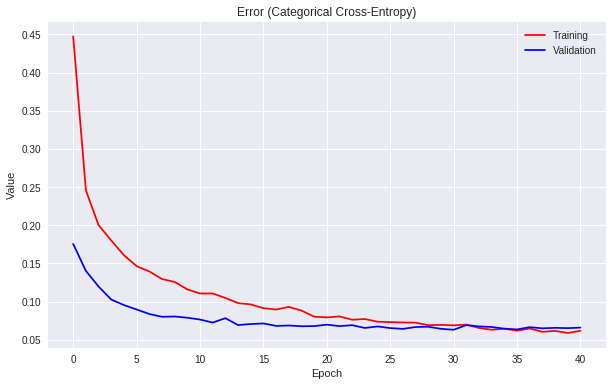

In [13]:
f, ax = plt.subplots()
f.set_size_inches(10, 6)
    
ax.plot(history.history["loss"], c="r")
ax.plot(history.history["val_loss"], c="b")
ax.set_title("Error (Categorical Cross-Entropy)")
ax.set_ylabel("Value")
ax.set_xlabel("Epoch")
ax.legend(["Training", "Validation"], loc="best");